In [1]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import re,os
import numpy as np

import kml2geojson
import json
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

/Users/ahakso/.virtualenvs/detroit/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview
The purpose of this nb is to give an example working with some geopandas syntax of taking city of detroit formatted data sets (csv and kml, which dominate the public data portal formats), and plot some information on a neighborhood grain

Data pulled from [the Open Data Portal](https://data.detroitmi.gov/)

This is not normalized by population, and doesn't produce anything particularly useful

In [35]:
neighborhood = kml_to_gpd('Current_City_of_Detroit_Neighborhoods')
blight = csv_with_x_y_to_gpd('Blight_Violations.csv')

/var/folders/28/p0bhwx8s3cj150l_wknp1wd80000gp/T/ipykernel_3537/486287638.py:2: DtypeWarning: Columns (9,11,15,16,17,30) have mixed types.Specify dtype option on import or set low_memory=False.
  blight = csv_with_x_y_to_gpd('Blight_Violations.csv')


In [40]:
df = gpd.sjoin(neighborhood.loc[:,['nhood_name','geometry']], blight, how='left', op='intersects')

In [43]:
counts = df.nhood_name.value_counts().to_frame('blight_violations').reset_index().rename(columns={'index':'nhood_name'})

In [45]:
blight_count_by_neighorhood = neighborhood.merge(counts,on='nhood_name')

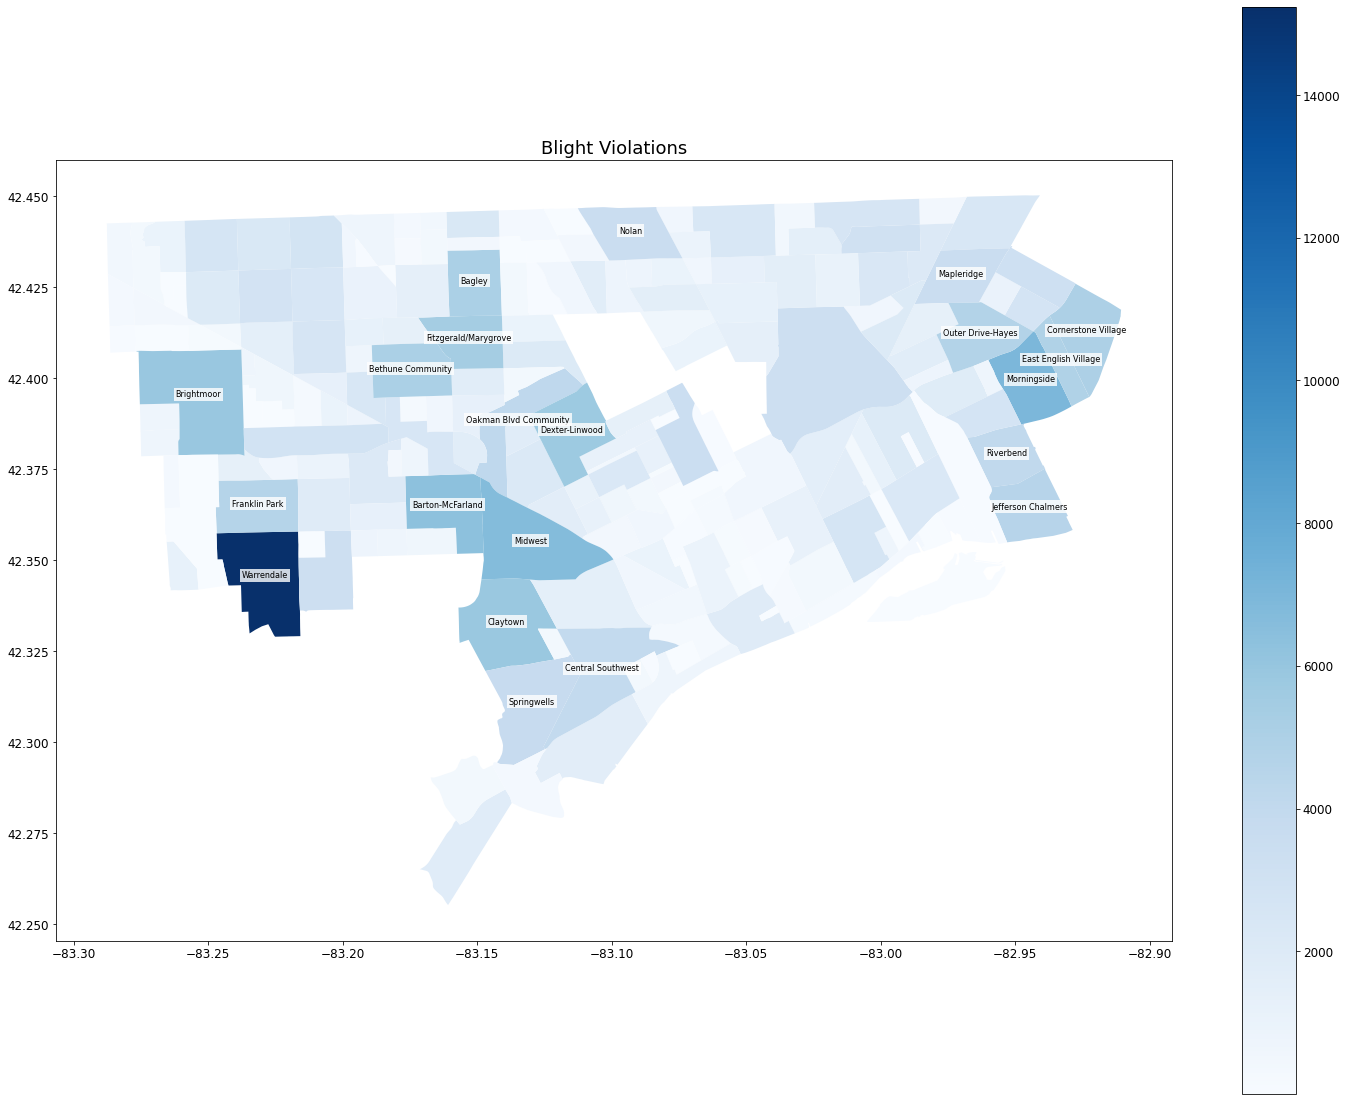

In [112]:
fig, ax = plt.subplots(1,1,figsize=(25,20))
blight_count_by_neighorhood.plot('blight_violations',ax=ax,cmap='Blues',legend=True)
ax.set(title='Blight Violations')

for idx, row in blight_count_by_neighorhood.iterrows():
#     plt.annotate(row.nhood_name,[x[0] for x in row.geometry.centroid.xy],fontsize=8)
    if row.blight_violations > blight_count_by_neighorhood.blight_violations.quantile(0.9):
        pts = [x[0] for x in row.geometry.centroid.xy]
        plt.text(pts[0],pts[1],row.nhood_name, fontsize=8,horizontalalignment='center',bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

# 911 calls for service

In [63]:
calls = csv_with_x_y_to_gpd('911_Calls_For_Service')

/var/folders/28/p0bhwx8s3cj150l_wknp1wd80000gp/T/ipykernel_3537/3982903492.py:1: DtypeWarning: Columns (14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  calls = csv_with_x_y_to_gpd('911_Calls_For_Service')


In [111]:
weapons = gpd.GeoDataFrame(pd.merge(
    calls.loc[calls.category.str.strip() == "WEAPON", :].groupby("neighborhood").agg(weapon_calls=('X','count')),
    neighborhood.loc[:, ["nhood_name","geometry"]],
    left_index=True,
    right_on="nhood_name",
))
weapons.head()

AttributeError: module 'geopandas' has no attribute 'merge'

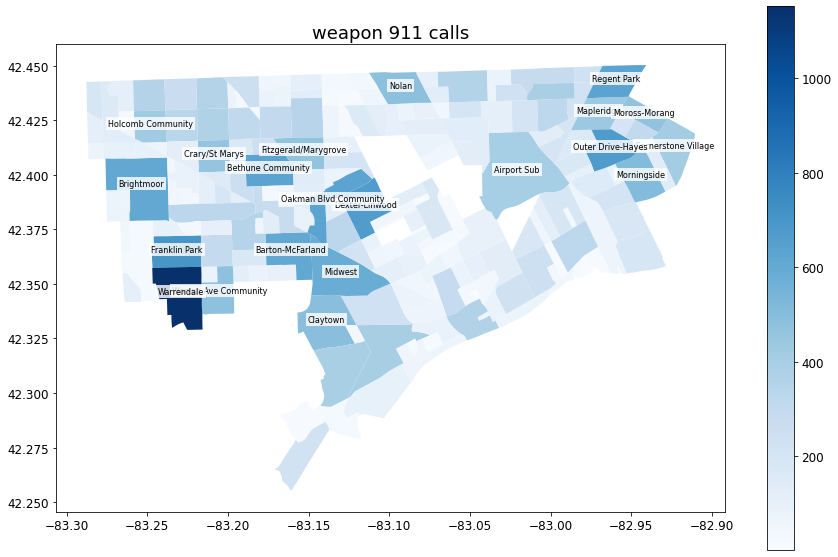

In [110]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
weapons.plot('weapon_calls',ax=ax,cmap='Blues',legend=True)
ax.set(title='weapon 911 calls')

top_decile = weapons.weapon_calls.quantile(0.9)
for idx, row in weapons.iterrows():
#     plt.annotate(row.nhood_name,[x[0] for x in row.geometry.centroid.xy],fontsize=8)
    if row.weapon_calls > top_decile:
        pts = [x[0] for x in row.geometry.centroid.xy]
        plt.text(pts[0],pts[1],row.nhood_name, fontsize=8,horizontalalignment='center',bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

In [117]:
neighborhood.columns

Index(['fill-opacity', 'stroke', 'stroke-opacity', 'OBJECTID',
       'council_district', 'nhood_num', 'nhood_name', 'Website', 'geometry'],
      dtype='object')